In [826]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [827]:
img_1 = cv2.cvtColor(cv2.imread('../images/Section-4/school/1.jpg', cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
# img_1 = cv2.imread('../images/Section-4/school/1.jpg', cv2.IMREAD_UNCHANGED)
img_1_gray = cv2.cvtColor(img_1, cv2.COLOR_RGB2GRAY)
img_2 = cv2.cvtColor(cv2.imread('../images/Section-4/school/2.jpg',cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB)
# img_2 = cv2.imread('../images/Section-4/school/2.jpg', cv2.IMREAD_UNCHANGED)
img_2_gray = cv2.cvtColor(img_2, cv2.COLOR_RGB2GRAY)


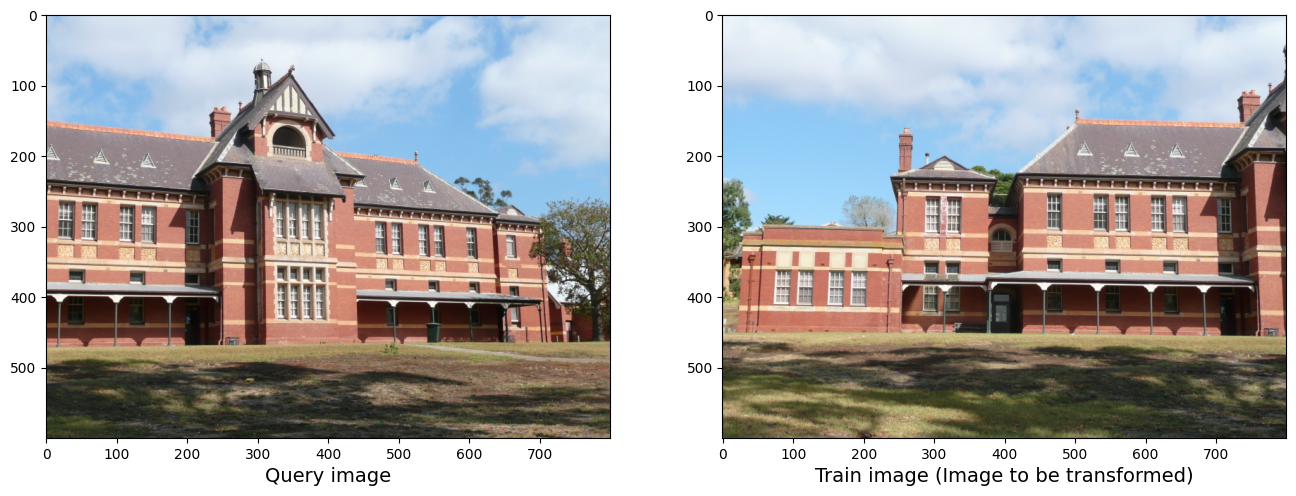

In [828]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(img_2, cmap="gray")
ax1.set_xlabel("Query image", fontsize=14)

ax2.imshow(img_1, cmap="gray")
ax2.set_xlabel("Train image (Image to be transformed)", fontsize=14)

plt.show()

In [829]:
descriptor = cv2.ORB_create()

In [830]:
img_1_gray = cv2.normalize(img_1_gray,None,0,255,cv2.NORM_MINMAX).astype('uint8')
img_2_gray = cv2.normalize(img_2_gray,None,0,255,cv2.NORM_MINMAX).astype('uint8')

In [831]:
kpsA, featuresA = descriptor.detectAndCompute(img_1_gray, None)

In [832]:
kpsB, featuresB = descriptor.detectAndCompute(img_2_gray, None)

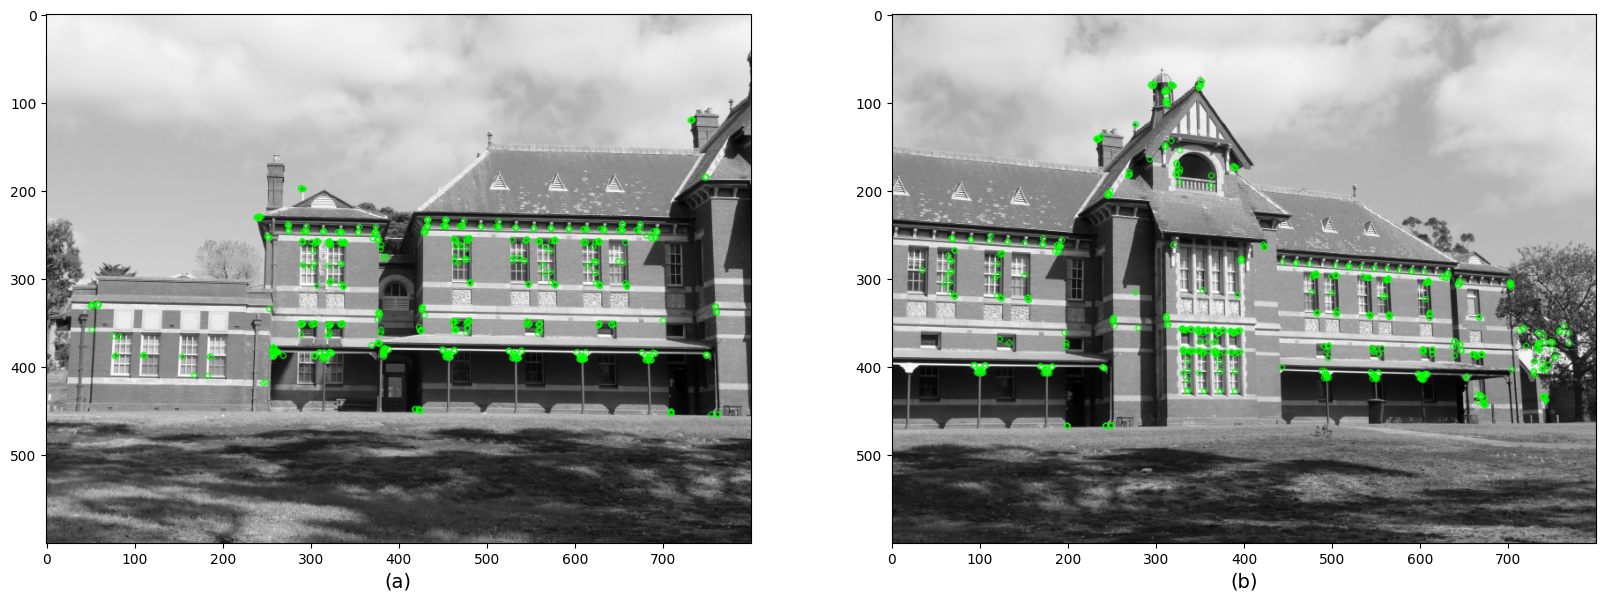

In [833]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(img_1_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(a)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(img_2_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(b)", fontsize=14)

plt.show()

In [834]:
def createMatcher(method,crossCheck):
    "Create and return a Matcher Object"
    
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb' or method == 'brisk':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

In [835]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
        
    # Match descriptors.
    best_matches = bf.match(featuresA,featuresB)
    
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

In [836]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    # compute the raw matches and initialize the list of actual matches
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

In [837]:
feature_matching = 'knn'
feature_extractor = 'sift'

Using: knn feature matcher
Raw matches (knn): 500


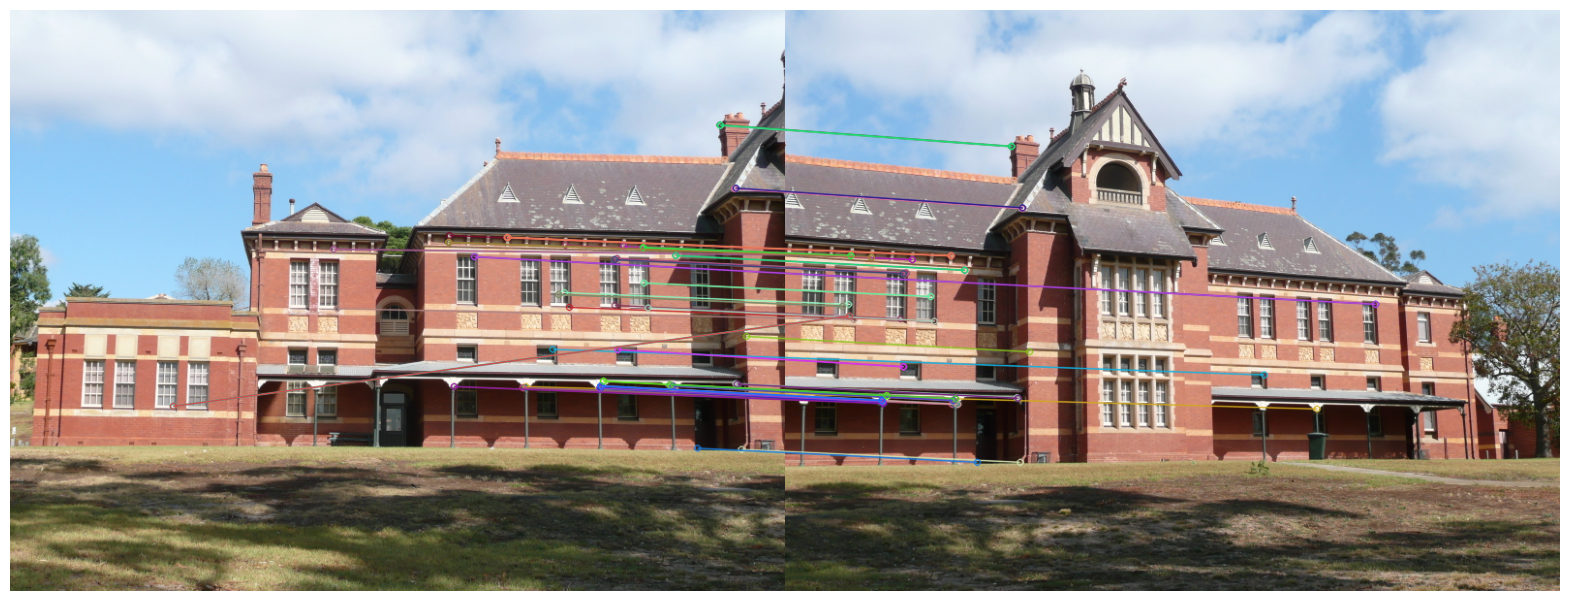

In [838]:
print("Using: {} feature matcher".format(feature_matching))

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(img_1,kpsA,img_2,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(img_1,kpsA,img_2,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
plt.axis("off")
plt.imshow(img3)
plt.show()

In [839]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [840]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 1.32824212e+00 -5.64136471e-02 -6.62558614e+02]
 [ 1.60739460e-01  1.24966065e+00 -8.29613173e+01]
 [ 4.22934873e-04 -4.86692533e-05  1.00000000e+00]]


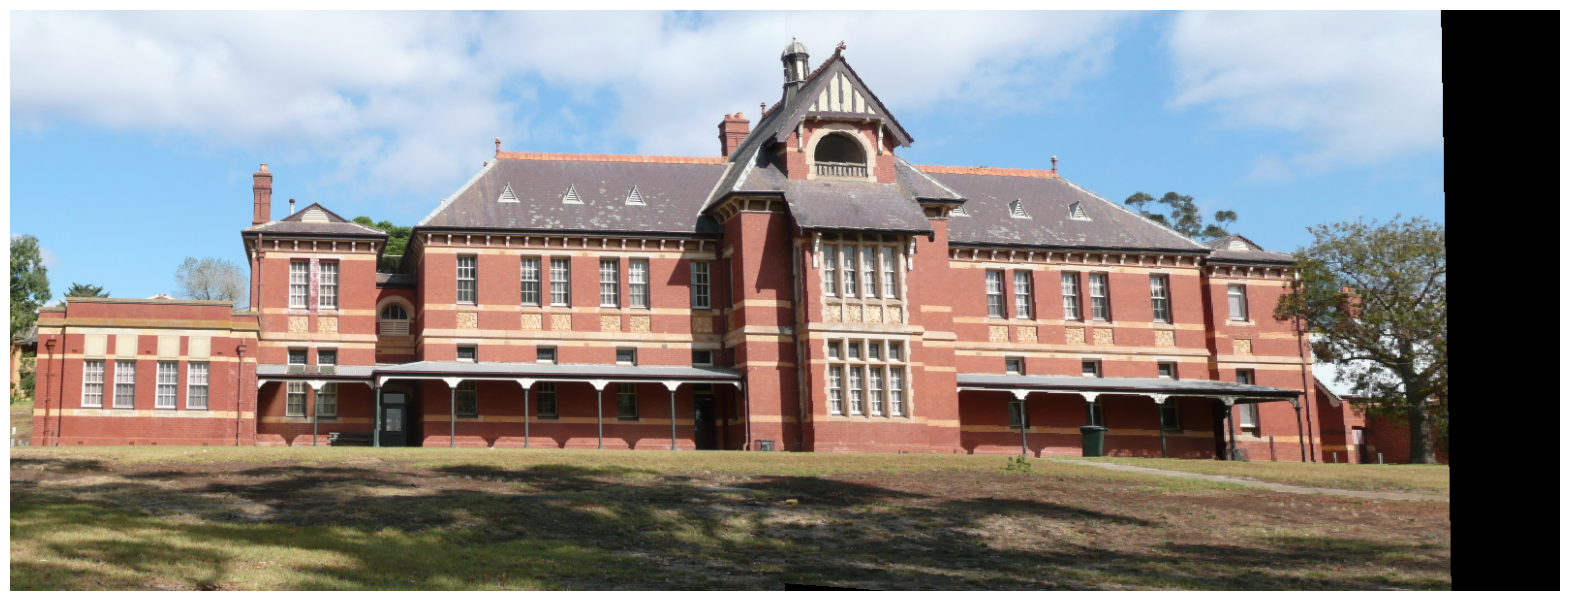

In [843]:
# Apply panorama correction
width = img_1.shape[1] + img_2.shape[1]
height = max(img_1.shape[0], img_2.shape[0])

result = cv2.warpPerspective(img_2, H, (width, height), flags=cv2.WARP_INVERSE_MAP)
result[0:img_1.shape[0], 0:img_1.shape[1], :] = img_1
# result += img_2
plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

In [842]:
result.shape

(600, 1600, 3)